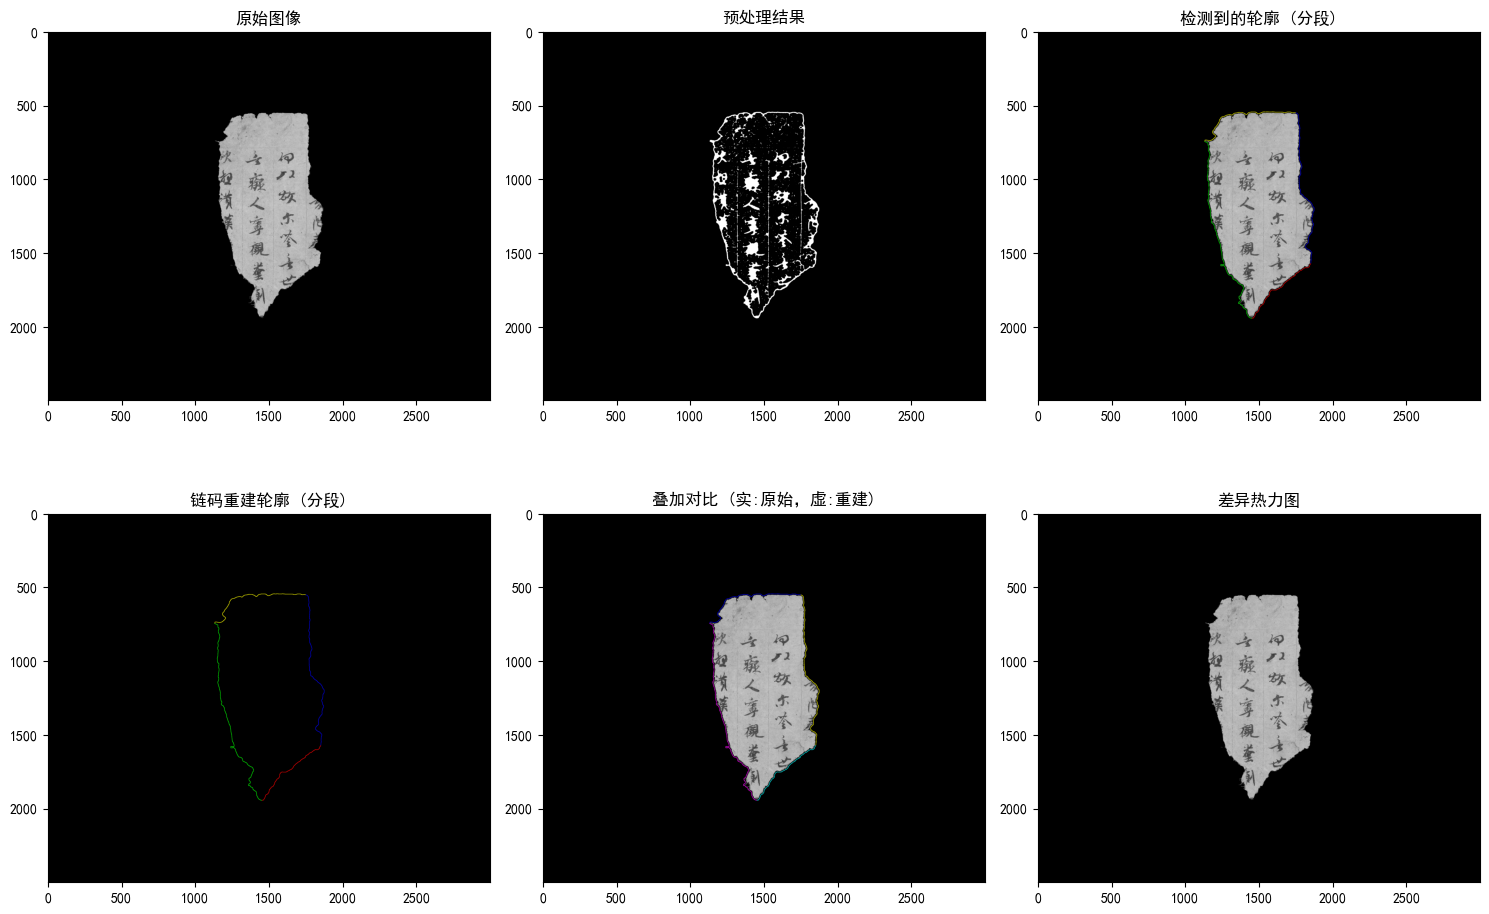

Segment 1 Chain Code: [2, 2, 1, 1, 0, 1, 0, 1, 0, 1]... (length: 1344)
Segment 2 Chain Code: [7, 0, 7, 0, 7, 0, 0, 0, 1, 7]... (length: 515)
Segment 3 Chain Code: [6, 6, 6, 6, 6, 7, 6, 6, 6, 6]... (length: 1053)
Segment 4 Chain Code: [4, 4, 4, 4, 5, 4, 4, 4, 4, 4]... (length: 722)


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 设置 matplotlib 支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def freeman_chain_code(contour, closed=True):
    """改进的Freeman链码生成函数，支持开放和闭合轮廓"""
    directions = [0, 1, 2, 3, 4, 5, 6, 7]
    dx = [1, 1, 0, -1, -1, -1, 0, 1]
    dy = [0, 1, 1, 1, 0, -1, -1, -1]
    chain_code = []
    n = len(contour)
    
    for i in range(n - 1 if not closed else n):
        current = contour[i % n][0]
        next_p = contour[(i + 1) % n][0]
        delta = (next_p[0] - current[0], next_p[1] - current[1])
        
        found = False
        for j, (ddx, ddy) in enumerate(zip(dx, dy)):
            if delta == (ddx, ddy):
                chain_code.append(j)
                found = True
                break
        if not found:
            raise ValueError(f"Invalid direction delta: {delta} at index {i}")
    
    return chain_code

# 图像读取（替换为你的实际路径）
image_path = r"C:\Users\28489\Desktop\paired\12\2.jpg"
original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 增强预处理流程
def preprocess(img):
    """改进的预处理管道"""
    blurred = cv2.GaussianBlur(img, (7, 7), 1.5)
    thresh = cv2.adaptiveThreshold(blurred, 255, 
                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY_INV, 21, 6)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
    return closed

processed = preprocess(original)

# 精确轮廓检测
contours, _ = cv2.findContours(processed, 
                              cv2.RETR_EXTERNAL, 
                              cv2.CHAIN_APPROX_NONE)

# 智能轮廓筛选
def is_valid_contour(cnt):
    """轮廓有效性验证"""
    area = cv2.contourArea(cnt)
    if area < 500:
        return False
    
    x, y, w, h = cv2.boundingRect(cnt)
    if (x == 0 or y == 0 or 
        x + w >= original.shape[1] - 1 or 
        y + h >= original.shape[0] - 1):
        return False
    
    solidity = area / (w * h)
    return 0.3 < solidity < 0.9

valid_contours = [cnt for cnt in contours if is_valid_contour(cnt)]

if not valid_contours:
    raise ValueError("未找到有效轮廓，请调整预处理参数")

# 选择最佳轮廓
best_contour = max(valid_contours, key=lambda c: cv2.contourArea(c))

# 轮廓近似为四边形
perimeter = cv2.arcLength(best_contour, True)
epsilon = 0.01 * perimeter
approx = cv2.approxPolyDP(best_contour, epsilon, True)

# 调整 epsilon 以确保恰好 4 个点
for _ in range(20):
    if len(approx) == 4:
        break
    elif len(approx) > 4:
        epsilon *= 1.1
    else:
        epsilon *= 0.9
    approx = cv2.approxPolyDP(best_contour, epsilon, True)
else:
    raise ValueError("无法近似为恰好 4 个点，请调整 epsilon 或预处理参数")

# 找到近似点在原始轮廓中的索引
contour_points = best_contour.reshape(-1, 2)
indices = []
for p in approx.reshape(-1, 2):
    distances = np.sum((contour_points - p)**2, axis=1)
    idx = np.argmin(distances)
    indices.append(idx)

# 确保索引按顺时针顺序排列
indices.sort()
if len(set(indices)) != 4:
    raise ValueError("近似点映射到重复索引，请减小 epsilon")

# 分割轮廓为四部分
seg1 = best_contour[indices[0]:indices[1]+1]
seg2 = best_contour[indices[1]:indices[2]+1]
seg3 = best_contour[indices[2]:indices[3]+1]
seg4 = np.vstack((best_contour[indices[3]:], best_contour[:indices[0]+1]))

# 为每个段生成 Freeman 链码（开放轮廓）
chain_codes = [
    freeman_chain_code(seg1, closed=False),
    freeman_chain_code(seg2, closed=False),
    freeman_chain_code(seg3, closed=False),
    freeman_chain_code(seg4, closed=False)
]

# 链码验证重建
def reconstruct_from_code(chain, start_point, img_shape, closed=False):
    """带路径验证的重建函数"""
    dx = [1, 1, 0, -1, -1, -1, 0, 1]
    dy = [0, 1, 1, 1, 0, -1, -1, -1]
    
    path = [start_point]
    current = np.array(start_point)
    
    for code in chain:
        step = np.array([dx[code], dy[code]])
        next_point = current + step
        
        next_point = np.clip(next_point, [0, 0], [img_shape[1]-1, img_shape[0]-1])
        path.append(next_point.copy())
        current = next_point
    
    return np.array(path, dtype=np.int32)

# 重建每段
start_points = [tuple(seg[0][0]) for seg in [seg1, seg2, seg3, seg4]]
reconstructed_segs = [
    reconstruct_from_code(chain_codes[i], start_points[i], original.shape, closed=False)
    for i in range(4)
]

# 可视化对比
plt.figure(figsize=(15, 10))

# 原始图像
plt.subplot(231)
plt.imshow(original, cmap='gray')
plt.title('原始图像')

# 预处理结果
plt.subplot(232)
plt.imshow(processed, cmap='gray')
plt.title('预处理结果')

# 分段轮廓
contour_img = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
colors = [(0,255,0), (255,0,0), (0,0,255), (255,255,0)]  # 绿、蓝、红、黄
segments = [seg1, seg2, seg3, seg4]
for seg, color in zip(segments, colors):
    cv2.polylines(contour_img, [seg], isClosed=False, color=color, thickness=2)

plt.subplot(233)
plt.imshow(contour_img)
plt.title('检测到的轮廓 (分段)')

# 重建结果
recon_img = np.zeros_like(contour_img)
for seg, color in zip(reconstructed_segs, colors):
    cv2.polylines(recon_img, [seg], isClosed=False, color=color, thickness=2)

plt.subplot(234)
plt.imshow(recon_img)
plt.title('链码重建轮廓 (分段)')

# 叠加对比
overlay = contour_img.copy()
for seg, color in zip(reconstructed_segs, colors):
    cv2.polylines(overlay, [seg], isClosed=False, color=(255-color[0], 255-color[1], 255-color[2]), thickness=2)

plt.subplot(235)
plt.imshow(overlay)
plt.title('叠加对比 (实:原始，虚:重建)')

# 误差分析
diff = cv2.absdiff(contour_img, recon_img)
plt.subplot(236)
plt.imshow(diff, cmap='jet')
plt.title('差异热力图')

plt.tight_layout()
plt.show()

# 打印链码供参考
for i, chain in enumerate(chain_codes):
    print(f"Segment {i+1} Chain Code: {chain[:10]}... (length: {len(chain)})")